In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sim_wc
from params_4_ThreeSequences import params
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import tools_wc
import copy
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', **{'family': 'serif', 'size': 20})
mpl.rcParams.update({'font.size': 20})
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example of cooperation

In [2]:
sim = sim_wc.Simulator(params)
sim.set_interaction_matrix()
t, r = sim.run()
r = r.T

In [3]:
sim_pair = sim_wc.Simulator(params)
sim_pair.set_interaction_matrix()
sim_pair.pair_sequences()
t, r_pair = sim_pair.run()
r_pair = r_pair.T

In [9]:
rE = r[:, ::2]
rE_pair = r_pair[:, ::2]

ValueError: x and y must have same first dimension, but have shapes (2500,) and (180, 15)

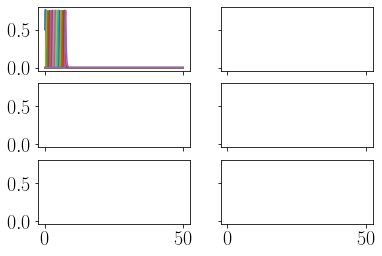

In [10]:
fig, ax = plt.subplots(len(params['seqs']), 2, sharex=True, sharey=True)
xlim = (0, 20)
for i, seq_i in enumerate(params['seqs']):
    ax[i, 0].plot(t, rE[:, seq_i[::2]])
    ax[i, 1].plot(t, rE_pair[:, seq_i[::2]])
    ax[i, 0].plot(t, rE[:, seq_i[::2]])
    ax[i, 0].set_ylabel(r'$r^{E,'+str(i)+'}$')
ax[0, 0].set_title(r'$s^1 - s^2$')
ax[0, 1].set_title(r'$s^1 \leftrightarrow s^2$')
ax[0, 0].set_xlim(xlim)
ax[-1, 0].set_xlabel('time')
ax[-1, 1].set_xlabel('time')
fig.tight_layout()

fig.savefig('figures/4_CooperationRequiresMutualInteractions_Example.svg')

## Including feed-forward inhibition further increases timescale

In [6]:
sim_pair = sim_wc.Simulator(params)
sim_pair.set_interaction_matrix()
sim_pair.pair_sequences(pot=[0.0165, 0.0165], type_proj='EE')
sim_pair.pair_sequences(pot=[0.004, 0.004], type_proj='EI')
t, r_pair = sim_pair.run()

In [7]:
rE = r[:, ::2]
rE_pair = r_pair[:, ::2]

ValueError: x and y must have same first dimension, but have shapes (2500,) and (180, 15)

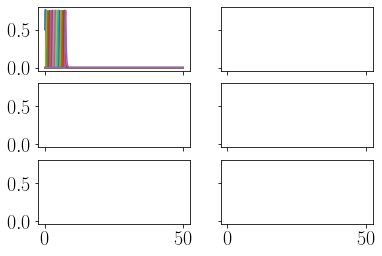

In [8]:
fig, ax = plt.subplots(len(params['seqs']), 2, sharex=True, sharey=True)
for i, seq_i in enumerate(params['seqs']):
    ax[i, 0].plot(t, rE[:, seq_i[::2]])
    ax[i, 1].plot(t, rE_pair[:, seq_i[::2]])
ax[0, 0].set_title('E')
ax[0, 1].set_title('I')
ax[0, 0].set_xlim(xlim)


## Cooperation requires mutual interaction

In [ ]:
t = params['t']

fname_res = 'data/4_r_cooperation.pckl'

In [ ]:
load_res = True

if load_res:
    r = tools_wc.load_pckl(fname_res)
    
else:

    r = np.zeros([
        len(params['range_pot_pairing0']),
        len(params['range_pot_pairing1']),
        len(t),
        len(np.concatenate(params['seqs']))*2,
        ])

    for i, pot_pr_0 in enumerate(tqdm(params['range_pot_pairing0'])):
        for j, pot_pr_1 in enumerate(params['range_pot_pairing1']):
            sim = sim_wc.Simulator(params)
            sim.set_interaction_matrix()
            sim.pair_sequences(pot=[pot_pr_0, pot_pr_1], type_proj='EE')
            _, r_ij = sim.run()
            r[i, j, :, :] = r_ij.T
    tools_wc.save_pckl(r, fname_res)

In [ ]:
rE = r[:, :, :, ::2]

crit = np.zeros([
    len(params['range_pot_pairing0']),
    len(params['range_pot_pairing1']),
    len(params['seqs'])
], dtype=bool)

dt = np.mean(np.unique(np.diff(params['t'])))

for i in range(len(params['range_pot_pairing0'])):
    for j in range(len(params['range_pot_pairing1'])):
        for m, seq_m in enumerate(params['seqs']):
            rE_ijm = rE[i, j, :, :][:, seq_m]  
            seq_m_pos = seq_m - seq_m[0]
            crit[i, j, m] = tools_wc.peak_criterium(rE_ijm, params['r_min'], seq_m_pos, params['tol'])

In [ ]:
crit_12lumped = np.zeros([
    len(params['range_pot_pairing0']),
    len(params['range_pot_pairing1']),
    2
], dtype=bool)

In [ ]:
crit_12lumped[:,:,0] = crit[:,:,0]
crit_12lumped[:,:,1] = np.logical_and(crit[:,:,1], crit[:,:,2])

In [ ]:
cmap = mpl.cm.get_cmap('Greys')

cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = [0, 0.9, 1.1, 2., 3.]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [ ]:
piv = np.sum(crit_12lumped, axis=2)
f = 0.1
piv = piv - f*crit_12lumped[:, :, 0]
piv = piv + f*crit_12lumped[:, :, 1]

fig, ax = plt.subplots(1, 2, squeeze=False, gridspec_kw={'width_ratios': [0.95, 0.05]}, figsize=(7,4))


ax[0,0].set_aspect('equal')
heatmap = ax[0,0].pcolormesh(
    params['range_pot_pairing0'],
    params['range_pot_pairing1'],
    piv.T, cmap=cmap, norm=norm)
#ax[0,0].axis('equal')
#ax[0,0].set_ylabel(r'n^{E,0}$')
#ax[0,0].set_xlabel(r'n^{E,1}$')
#ax[0,0].set_xticks([params['range_nE1'][0], params['range_nE1'][-1]])
#ax[0,0].set_yticks([params['range_pot_ff1'][0], params['range_pot_ff1'][-1]])
#ax[0,0].set_title('Competition scenarios', fontsize=24)

ax2 = ax[0, 1]

# adjust ticklabels to represent pff instead of potentiation factor
yticks = ax[0,0].get_yticks()
yticks = yticks[:-1]
yticks_m = yticks*params['p_ff']
#ax[0,0].set_yticklabels(np.round(yticks, 5))
ax[0,0].set_yticks(yticks)
ax[0,0].set_yticklabels([str(i) for i in yticks_m])

ax[0,0].set_ylabel(r'$p^{21}_{ff}$')

xticks = ax[0,0].get_xticks()
xticks = xticks[:-1]
xticks_m = xticks*params['p_ff']
#ax[0,0].set_xticklabels(np.round(xticks, 5))
ax[0,0].set_xticklabels([str(i) for i in xticks_m], rotation=30)
ax[0,0].set_xticks(xticks)
ax[0,0].set_xlabel(r'$p^{12}_{ff}$')

cb = mpl.colorbar.ColorbarBase(
    ax2, cmap=cmap, norm=norm,
    #spacing='proportional',
    #ticks=[0.5, 1., 1.5, 2.5],
    ticks=[0.5, 1., 1.5],
    boundaries=bounds[:-1], format='%2i')
cb.ax.set_yticklabels(
    ['winnerless',
     '$s^0$ wins',
     '$s^1$ and $s^2$ win'])

fig.tight_layout()

fig.savefig('figures/4_CooperationRequiresMutualInteractions.svg')